# Conveyor Belt Thermodynamic Integration with Ensembler
In this notebook, we give examples how to run conveyor belt simulations with Ensembler. 

Maintainers: [@SchroederB](https://https://github.com/SchroederB), [@linkerst](https://https://github.com/linkerst), [@dfhahn](https://https://github.com/dfhahn)

## Loading Ensembler and necessary external packages 

In [1]:
import os, sys
sys.path.append(os.getcwd()+"/..")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colorbar
from mpl_toolkits.mplot3d import Axes3D

import ensembler.potentials.OneD as pot
import ensembler.system.perturbed_system as system
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.samplers import stochastic

## Interactive Example
The following is an interactive example, which explains the concept of the conveyor belt algorithm. The graph shows a free energy surface $G$ dependent on $\lambda$ ranging from 0 to 1 (or from state A to state B). On top of the free energy surface are the system replicas, which are connected to the conveyor belt. The replicas are placed equidistantly on the conveyor belt on a forward-turn-backward-turn path and move concertedly along the conveyor belt, thereby sampling the whole free energy surface.

The left sliders allow you to change the position of the conveyor belt variable $\Lambda$ from 0 to 360 deg (or 0 to $2\pi$) and the number of replicas.

In [2]:
from ensembler.visualisation.interactive_plots import interactive_conveyor_belt

iwidget = interactive_conveyor_belt()
iwidget

AppLayout(children=(VBox(children=(Play(value=0, description='rotate', max=360), HBox(children=(IntSlider(valu…

## Build a conveyor belt object
For building a `conveyorBelt` object, you first have to build a `system`, which will be used as a template for the replicas. The `system` itself needs to to be initialized with a potential and an integrator. For details, see the Tutorial Simulations.

In [3]:
sampler = stochastic.metropolisMonteCarloIntegrator()
potential = pot.linearCoupledPotentials(Va = pot.harmonicOscillatorPotential(k=1, x_shift=0.0),
    Vb = pot.harmonicOscillatorPotential(k=2, x_shift=2.0))
sys = system.perturbedSystem(potential=potential , 
                              sampler=sampler)

Additional the number of replicas `n_replicas` and the initial capital Lambda value needs to be specified. The latter can usually be set to 0. An additional (optional) argument is the `build` variable, which will be discussed later.

The output shows the current state of the conveyor belt as a table with the replica ID, the corresponding lambda value and the energy of the replica.

In [4]:
ensemble = cvb.conveyorBelt(capital_lambda=0.0,
                            n_replicas=4,
                            system=sys)
ensemble

i    lambda_i  E_i       
-------------------------
    0      0.00    43.400
    1      0.50    43.400
    2      1.00    43.400
    3      0.50    43.400

## Start a conveyor belt simulation 
The conveyor belt is simulated by using its member function `simulate` with the number of steps as argument. 

In [5]:
steps = 100
ensemble.simulate(steps)

The trajectories of the ensemble `cvb_traj` and the single systems `sys_trajs` can be retrieved by using its member function `get_trajs`.

In [6]:
(cvb_traj, systrajs) = ensemble.get_trajs()

The ensemble trajectory is a `pandas.DataFrame` object with the following columns:
- **Step**: index of frame (starting from 1)
- **capital_lambda**: the capital lambda of the frame
- **TotE**: the current total energy of the ensemble
- **biasE**: the current bias energy
- **doAccept**: information whether the Monte Carlo step before the frame was accepted or not

In [7]:
cvb_traj.head()

,Step,capital_lambda,TotE,biasE,doAccept
0,0,0.000000,173.598044,0.0,True
1,0,5.817869,173.598044,0.0,True
2,1,0.235479,198.878540,0.0,True
3,2,0.690932,91.945244,0.0,True
4,3,0.781575,37.977866,0.0,True


The system trajectory object `systrajs` is a `list` of `pandas.DataFrame` objects (one per replica) with the following columns:
- **position**: (spatial) position of particle
- **temperature**: temperature
- **total_system_energy**: the current total energy of the replica
- **total_potential_energy**: the current potential energy of the replica
- **total_kinetic_energy**: the current kinetic energy of the replica
- **dhdpos**: the derivative of the hamiltonian with repect to the position (negative of the force)
- **velocity**: velocity of the particle
- **lam**: lambda value of the particle
- **dhdlam**: Hamiltonian derivative with respect to lambda
The kinetic energy and the velocity are `NaN` in the following, becauce this example uses the stochastic `metropolisMonteCarloIntegrator`, which does not calculate velocities.

In [8]:
systrajs[0].head()

,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity,lam,dhdlam
0,-5.5651964852779034,298.0,21.668981,21.668981,NaN,3.751402776814381,NaN,0.148115,41.746492
1,-3.303361429401436,298.0,7.155303,7.155303,NaN,2.2618350558764675,NaN,0.074955,22.669544
2,-3.3216545485411837,298.0,10.531838,10.531838,NaN,-0.01829311913974785,NaN,0.219930,22.803313
3,1.451313754499087,298.0,0.866046,0.866046,NaN,4.772968303040271,NaN,0.248783,-0.752099
4,-0.46381759222464103,298.0,1.406358,1.406358,NaN,-1.915131346723728,NaN,0.217815,5.962834


## Visualizations of the trajectories

The following graph shows exemplarious the trajectories and histograms of the lambda variables of the single replicas. Other of the above mentioned variables can be plottet in the same way.

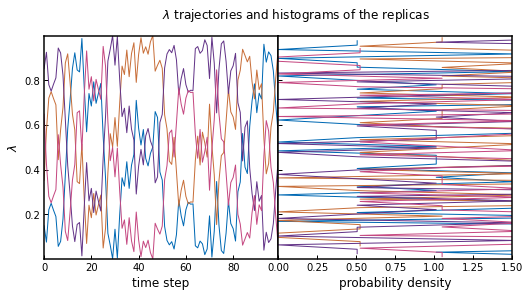

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for i in systrajs:
    ax[0].plot(systrajs[i].index, systrajs[i].lam, label=f"{i}")
    h1=np.histogram(systrajs[i].lam, bins=50, density=1)
    ax[1].plot( h1[0], (h1[1][:-1]+h1[1][1:])/2)
ax[0].set_xlabel("time step")
ax[1].set_xlabel("probability density")
ax[0].set_ylabel("$\lambda$")
ax[1].set_xlim(0, 1.5)
out = plt.suptitle("$\lambda$ trajectories and histograms of the replicas", x=.6, y=1.0)

## Simple analysis of the conveyor belt simulation
First, we simulate the conveyor belt even longer to get more statistics. To account for equilibration, we discard the first hundred steps of each trajectory.

In [10]:
ensemble.simulate(2000)
(cvb_traj, systrajs) = ensemble.get_trajs()
cvb_traj = cvb_traj.iloc[100:]
for i, traj in systrajs.items():
    systrajs[i] = traj.iloc[100:]

In [11]:
nbins=100
bins=np.zeros(nbins)
dhdlbins=np.zeros(nbins)
for i in systrajs:
    for j, row in systrajs[i].iterrows():
        index=int(np.floor(row.lam*nbins))
        if index == nbins:
            index=nbins-1
        bins[index]+=1
        dhdlbins[index]+=row.dhdlam
# avoid division by zero by setting elements == 0 to 1
bins = np.where(bins, bins, 1)
dhdlbins/=bins

The plotted `<dhdlam>(lam)` curve is similar to the curves you get from TI simulations, but is usually base on more lambda points. 

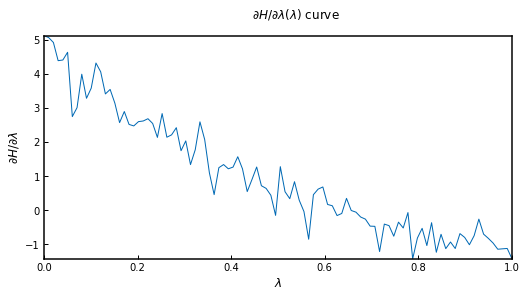

In [12]:
fig = plt.figure(figsize=(10,4))
plt.plot(np.linspace(0,1,nbins), dhdlbins)
plt.xlabel("$\lambda$")
plt.ylabel("$\partial H / \partial \lambda$")
out = plt.suptitle("$\partial H / \partial \lambda (\lambda)$ curve", x=.6, y=1.0)

The integral of this curve gives the free energy estimate. As you have many points along $\lambda$, you can use the rectangular integration:

In [13]:
integral=np.sum(dhdlbins)*1.0/nbins
print(f'Delta G = {integral:.2f} kJ/mol')

Delta G = 1.01 kJ/mol


This value agrees with the analytical value, which is calculated below. More replicas and longer sampling will improve the e

In [15]:
#analytical
u=1.66053886e-27
NA=6.0221415e23
hbar=1.054571800e-34*1e12*1e-3*NA  #kJ/mol*ps
R=0.00831446 #kJ/mol/K
mu=0.5  #u
T=300.0  #K
fc1=1  #kJ/nm^2/mol
fc2=2.0 #kJ/nm^2/mol
omega1=np.sqrt(fc1/mu)
omega2=np.sqrt(fc2/mu)
alpha1=hbar*np.sqrt(fc1/mu)/(R*T)
alpha2=hbar*np.sqrt(fc2/mu)/(R*T)
Z1=np.exp(-alpha1/2.0)/(1-np.exp(-alpha1))
Z2=np.exp(-alpha2/2.0)/(1-np.exp(-alpha2))
DF=-R*T*np.log(Z2/Z1)
print(f'Analytical value = {DF:.2f} kJ/mol')

Analytical value = 0.86 kJ/mol
